In [3]:
# установка необходимых библиотек
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import time
import csv

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

# вывод графика и сохранение в ноутбуке
%matplotlib inline

In [ ]:
tf.__version__

'2.6.4'

In [5]:
# загрузка обучающего и валидационного датафреймов из csv-файлов
train_df = pd.read_csv('train_df.csv', index_col = 0) 
test_df = pd.read_csv('test_df.csv', index_col = 0)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40037 entries, 46357 to 14269
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  40037 non-null  object
 1   emotion     40037 non-null  object
dtypes: object(2)
memory usage: 938.4+ KB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10009 entries, 2 to 50040
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10009 non-null  object
 1   emotion     10009 non-null  object
dtypes: object(2)
memory usage: 234.6+ KB


In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
N_CLASSES = 9

In [ ]:
# генератор обучающих данных с функцией аугментации
train_generator = ImageDataGenerator(
                                     rotation_range=15,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     brightness_range=(0.5,1.5),
                                     shear_range=0.1,
                                     zoom_range=.1,
                                     preprocessing_function=preprocess_input
                                     )
        
train_data_gen = train_generator.flow_from_dataframe(dataframe=train_df,
                                                     x_col='image_path',
                                                     y_col='emotion',
                                                     target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='sparse',
                                                     shuffle=True,
                                                     interpolation='nearest',
                                                    )

# генератор валидационных данных
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

val_data_gen = val_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='image_path',
                                                 y_col='emotion',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='sparse',
                                                 shuffle=False,
                                                 interpolation='nearest',
                                                )

Found 40037 validated image filenames belonging to 9 classes.
Found 10009 validated image filenames belonging to 9 classes.


In [6]:
# загрузка обученной модели MobileNetV2
mobilenetv2_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),        
                                               include_top=False,
                                               weights='imagenet')
mobilenetv2_model.trainable = False # замораживаем всю базовую модель
mobilenetv2_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [7]:
# создание модели с дополнительными слоями для решения моей задачи
model = tf.keras.Sequential([
    mobilenetv2_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(N_CLASSES)])
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 512)               32113152  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 34,375,753
Trainable params: 32,117,769
Non-trainable params: 2,257,984
____________________________________

In [ ]:
# создание папки модели и имени файла для записи весов во время обучения
path = Path('model_MobileNetV2')
path.mkdir(exist_ok=True, parents=True) # папка создается на вашем гугл диске вместе с "родителями"
assert path.exists()
cpt_filename = 'best_checkpoint.hdf5'  
cpt_path = str(path / cpt_filename)

In [ ]:
# обратный вызов для сохранения весов модели
checkpoint = ModelCheckpoint(cpt_path,
                            verbose=1,
                            save_best_only=True,
                            save_weights_only=True,
                            save_freq='epoch',
                            mode='min')

In [ ]:
# функция экспоненциального затухания к шагу оптимизатора с заданной начальной скоростью обучения
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=100,
    decay_rate=0.9)

# настройка модели для обучения
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

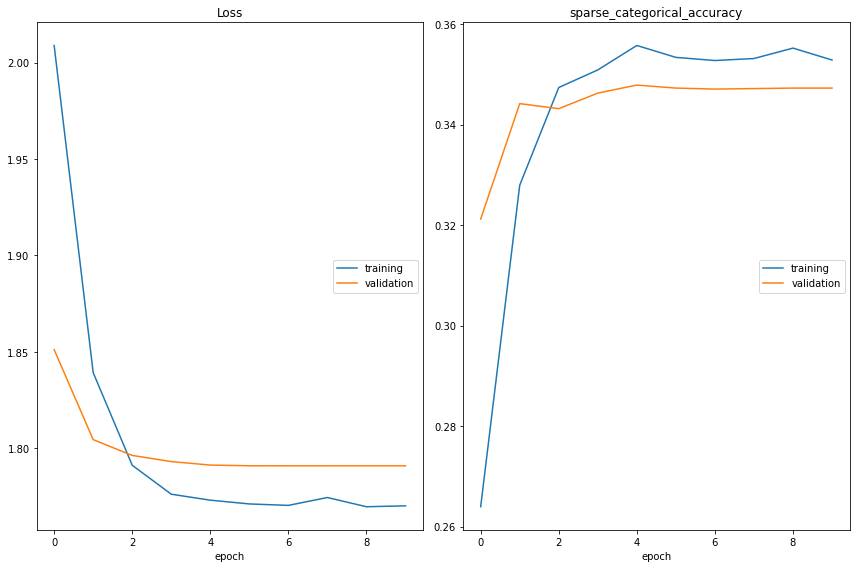

Loss
	training         	 (min:    1.770, max:    2.009, cur:    1.770)
	validation       	 (min:    1.791, max:    1.851, cur:    1.791)
sparse_categorical_accuracy
	training         	 (min:    0.264, max:    0.356, cur:    0.353)
	validation       	 (min:    0.321, max:    0.348, cur:    0.347)


In [ ]:
# обучение модели
EPOCHS = 10
history = model.fit(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen,
                    callbacks=[checkpoint,
                               PlotLossesCallback()
                              ]
                    )

In [ ]:
# значение потерь и значения метрики для модели в тестовом режиме
model.evaluate(val_data_gen)

313/313 [==============================] - 71s 226ms/step - loss: 1.7908 - sparse_categorical_accuracy: 0.3473


[1.7908124923706055, 0.34728744626045227]

In [14]:
# запись весов модели
model.save_weights('model_MobileNetV2/weights.h5')

In [13]:
# запись конфигурации модели
model_json = model.to_json()
with open("model_MobileNetV2/model.json","w") as json_file:
    json_file.write(model_json)

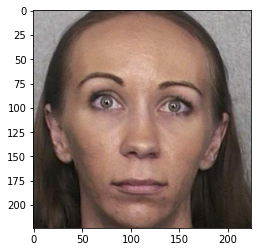

In [ ]:
# случайный выбор и обработка изображения для теста
rng = np.random.default_rng()
n = rng.integers(5000, size=1)[0]
img = image.load_img('test_kaggle/' + str(n) + '.jpg', target_size=(224, 224))
x = image.img_to_array(img, dtype=np.uint8)
x = np.expand_dims(x, axis=0)
plt.imshow(img)

In [ ]:
# определение времени инференса сети
%%timeit 
#-n 10 -r 10

model.predict(preprocess_input(x))

46.9 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
# создание словаря эмоций из файла
def load_dict_from_file(path):
    f = open(path,'r')
    data=f.read()
    f.close()
    return eval(data)

emotion_mapping = load_dict_from_file('dict.txt')
emotion_mapping

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise',
 8: 'uncertain'}

In [ ]:
# определение эмоции на тестовом изображении
predicted = model.predict(preprocess_input(x))
emotion_mapping[np.argmax(predicted)]

'neutral'

In [ ]:
# создание списка для структруированного по заданию итогового csv-файла из файла 
def load_list_from_file(path):
    f = open(path,'r')
    data=f.read()
    f.close()
    return eval(data)

my_list = load_list_from_file('test_list.txt')   

In [ ]:
# запись итогового csv-файла
with open('submission_mobilenetv2.csv', 'w') as f:
    fieldnames = ['image_path', 'emotion']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for name in my_list:
        img = image.load_img('test_kaggle/'+ name, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        predicted_arr = model.predict(preprocess_input(x))
        predicted = emotion_mapping[np.argmax(predicted_arr)]
        writer.writerow({'image_path': name.replace('test_kaggle/', ''), 'emotion': predicted})

### Оценки Kaggle

Score: 0,32720

Public score: 0,34640